In [ ]:

!pip install pyqubo
!pip install rustworkx

!pip install docplex
!pip install qiskit
!pip install qiskit-optimization


In [ ]:
!pip install 'qiskit-optimization[cplex]'

In [25]:
import random

In [26]:
import csv
from shapely.wkt import loads

def parse_csv_file(file_path):
    # Initialize empty lists to store the extracted values
    latitudes = []
    longitudes = []
    names = []

    with open(file_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present

        # Loop over each row in the csv using reader object
        for row in reader:
            # row variable is a list that represents a row in csv
            latitude = float(row[1])
            longitude = float(row[2])
            name = row[0]
            # Append the values to the respective lists
            latitudes.append(latitude)
            longitudes.append(longitude)
            names.append(name)

    return latitudes, longitudes, names

# Path to the CSV file
file_path = './data/bus_station_location.csv'

# Call the function to parse the data from the file
latitudes, longitudes, names = parse_csv_file(file_path)

coordinates = {}

for lat, lon, n in zip(latitudes, longitudes, names):
  coordinates[n] = [lat,lon]

print(coordinates)

# 40.769033,-73.969649
# select all the bus stations between 4km and 9km of the given coordinates
selected_coordinates = {}
for k,v in coordinates.items():
  if (v[0]-40.769033)**2 + (v[1]+73.969649)**2 >= 0.01 and (v[0]-40.769033)**2 + (v[1]+73.969649)**2 <= 0.20:
    selected_coordinates[k] = v


{'Central Park': [40.769033, -73.969649], 'Sunset Park (Central)': [40.636607, -74.01154], 'Prospect Park': [40.66007, -73.977772], 'Upper East Side-Lenox Hill-Roosevelt Island': [40.766741, -73.956738], 'Gravesend (West)': [40.600434, -73.995232], 'Chelsea-Hudson Yards': [40.747927, -74.003847], 'Fort Wadsworth': [40.599129, -74.062971], 'East Elmhurst': [40.767857, -73.880212], 'Midtown South-Flatiron-Union Square': [40.74986, -73.987669], 'Sunnyside': [40.744165, -73.925245], 'Grasmere-Arrochar-South Beach-Dongan Hills': [40.598413, -74.0919], 'East Harlem (South)': [40.785357, -73.949465], 'University Heights (South)-Morris Heights': [40.850268, -73.915494], 'Midtown-Times Square': [40.75357, -73.98098], 'Carroll Gardens-Cobble Hill-Gowanus-Red Hook': [40.674894, -74.001108], 'West New Brighton-Silver Lake-Grymes Hill': [40.634584, -74.117749], 'Upper East Side-Yorkville': [40.774585, -73.950985], 'Cypress Hills': [40.681721, -73.871923], 'New Springville-Willowbrook-Bulls Head-Tra

In [27]:
# select 20 random bus stations
random.seed(42)
selected_coordinates = dict(random.sample(list(selected_coordinates.items()), 20))

In [28]:
for (key, value) in selected_coordinates.items():
    print(key, value)

Sunset Park (West) [40.653814, -74.00524]
Fort Wadsworth [40.599129, -74.062971]
Bensonhurst [40.606983, -74.002384]
Woodhaven [40.693813, -73.851904]
Port Richmond [40.633841, -74.125398]
Mariner's Harbor-Arlington-Graniteville [40.63699, -74.159932]
Annadale-Huguenot-Prince's Bay-Woodrow [40.531413, -74.217676]
Coney Island-Sea Gate [40.577395, -74.000262]
Rosedale [40.66568, -73.73623]
Grasmere-Arrochar-South Beach-Dongan Hills [40.598413, -74.0919]
Howard Beach-Lindenwood [40.664506, -73.849797]
West New Brighton-Silver Lake-Grymes Hill [40.634584, -74.117749]
Gravesend (South) [40.592785, -73.978889]
College Point [40.781563, -73.846043]
Bath Beach [40.608191, -74.001599]
Jamaica [40.712528, -73.784081]
Prospect Park [40.66007, -73.977772]
East New York (North) [40.676651, -73.890777]
Arden Heights-Rossville [40.550223, -74.187657]
Brownsville [40.67504, -73.904496]


In [29]:
stations_dic = {}
input_file_path = "./data/station_distance.csv"

with open(input_file_path, "r") as input_file:
    next(input_file, None)
    for line in input_file:
        fields = line.strip().split(",")
        start = fields[0]
        end = fields[1]
        duration = float(fields[2])
        key = (start, end)
        stations_dic[key] = duration

In [37]:
# calculate the f and g for each station
# f is the number of people getting off at the station
# g is the distance from the nearest touristic site

def get_no_of_people_at_station(selected_coordinates):
    pop_at_station = {}
    with open("./data/station_pop_clean.csv", "r") as input_file:
        next(input_file, None)
        for line in input_file:
            fields = line.strip().split(",")
            station = fields[1]
            pop = float(fields[4])
            if station in selected_coordinates.keys():
                pop_at_station[station] = pop
    
    return pop_at_station

def get_distance_from_nearest_site(selected_coordinates):
    distance_from_site = {}
    with open("./data/bus_metro_distance.csv", "r") as input_file:
        next(input_file, None)
        for line in input_file:
            fields = line.strip().split(",")
            station = fields[0]
            distance = float(fields[2])
            if station in selected_coordinates.keys():
                distance_from_site[station] = distance
    
    return distance_from_site

def get_delay_from_nearest_station(selected_coordinates):
    delay_from_station = {}
    with open("./data/metro_delay.csv", "r") as input_file:
        next(input_file, None)
        for line in input_file:
            fields = line.strip().split(",")
            station = fields[1]
            delay = float(fields[3])
            if station in selected_coordinates.keys():
                delay_from_station[station] = delay
    
    return delay_from_station

def normalize(dic):
    max_value = max(dic.values())
    min_value = min(dic.values())
    for key in dic.keys():
        dic[key] = (dic[key] - min_value) / (max_value - min_value)
    return dic

In [38]:
#node dictionary
node_dic = {}
f_list = get_no_of_people_at_station(selected_coordinates)
g_list = get_distance_from_nearest_site(selected_coordinates)
h_list = get_delay_from_nearest_station(selected_coordinates)

print(h_list)

f_list = normalize(f_list)
g_list = normalize(g_list)
h_list = normalize(h_list)

# print(f_list)

for (key, _) in selected_coordinates.items():
  # print(key)
  if (key in f_list) and (key in g_list):
    node_dic[key] = { 'name':key , 'f': f_list[key] , 'g': g_list[key], 'h': h_list[key]}

C = 5
D = 3
E = 0.3

temp = {node: {"name": attrs["name"], "c": C*attrs["f"] + D*attrs["g"] + E*attrs["h"]}
                 for node, attrs in node_dic.items()}
node_dic = temp

#node index dictionary
index_dic = {}

index = 0
for node in node_dic:
  index_dic[node] = index
  index+=1

# #edge dictionary
# edge_dic = {}

# # edges only between nodes w 30 min distance
# for item in stations_dic.items():
#   dur = item[1]
#   if dur <= 30:
#     edge_dic[item[0]] = {'cost': dur}

# will add edges for all the nodes considered
edge_dic = {}
for item in stations_dic.items():
  if (item[0][0] in node_dic) and (item[0][1] in node_dic) and item[1] <= 25:
    edge_dic[item[0]] = {'cost': item[1]}

{'Sunset Park (West)': 5.0, 'Fort Wadsworth': 6.0, 'Bensonhurst': 4.0, 'Woodhaven': 3.0, 'Port Richmond': 3.0, 'Coney Island-Sea Gate': 4.0, 'Rosedale': 5.0, 'Grasmere-Arrochar-South Beach-Dongan Hills': 6.0, 'Howard Beach-Lindenwood': 4.0, 'West New Brighton-Silver Lake-Grymes Hill': 6.0, 'Gravesend (South)': 4.0, 'College Point': 3.0, 'Bath Beach': 4.0, 'Jamaica': 3.0, 'Prospect Park': 3.0, 'East New York (North)': 4.0, 'Arden Heights-Rossville': 3.0, 'Brownsville': 3.0}


In [39]:
# get the number of nodes and edges
num_nodes = len(node_dic)
num_edges = len(edge_dic)

print("num_nodes:", num_nodes)
print("num_edges:", num_edges)

num_nodes: 12
num_edges: 56


**API to calculate distance between nodes (stations)**


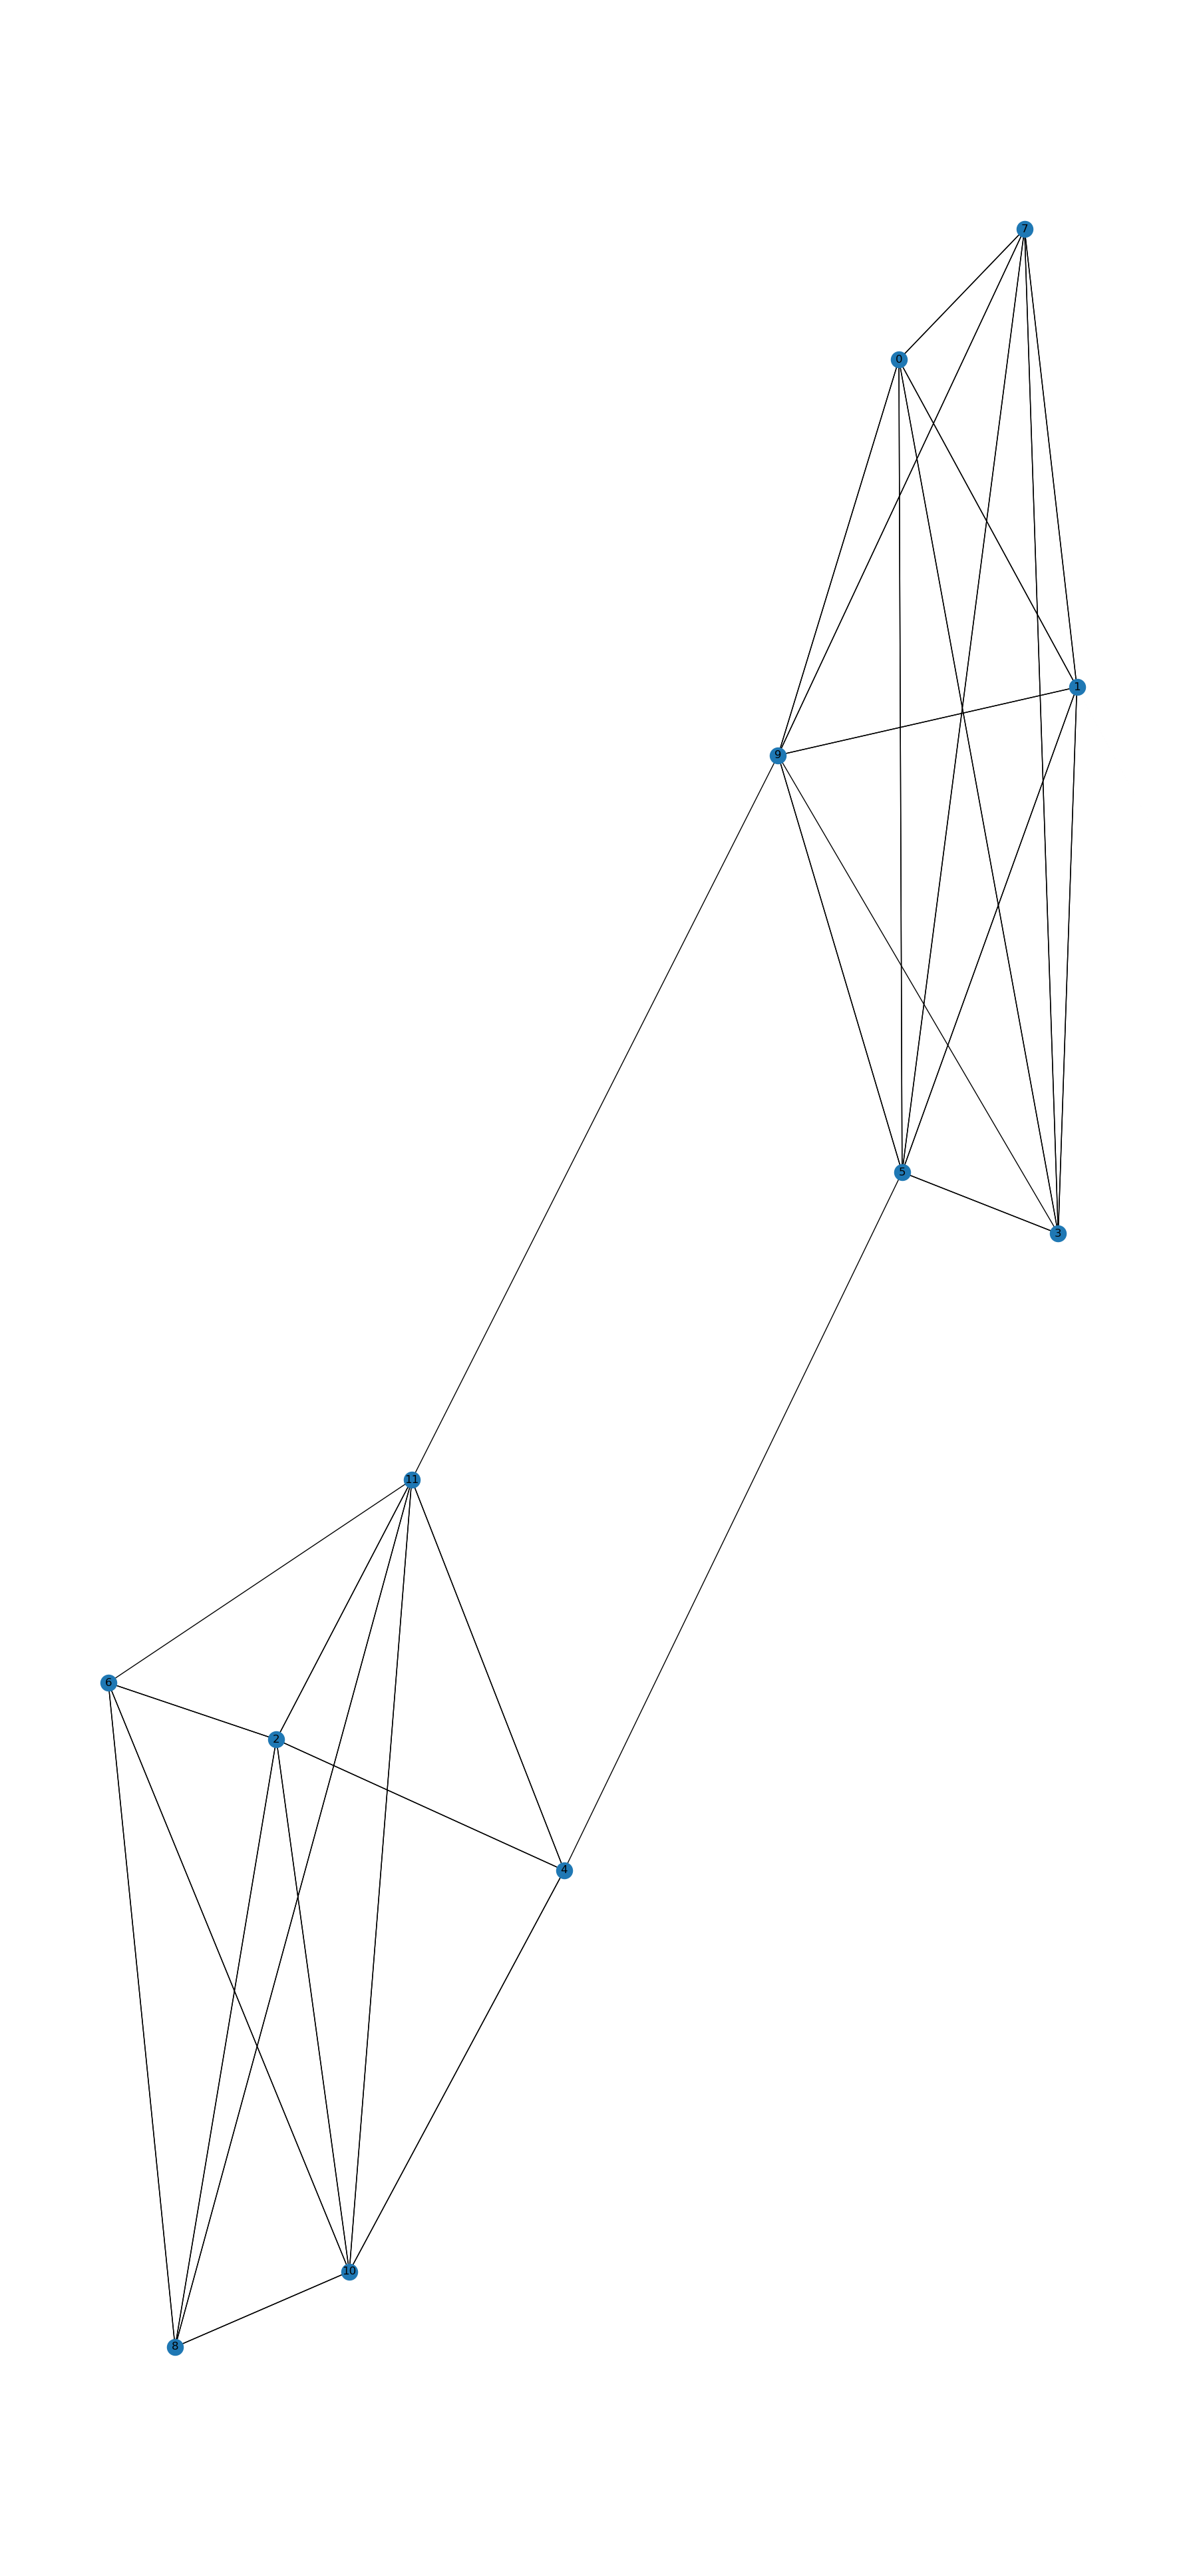

In [40]:
import rustworkx
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw

graph = rustworkx.PyGraph()

for node in node_dic.items():
  graph.add_node(node[1])

for edge in edge_dic.items():
  graph.add_edge( index_dic[edge[0][0]] , index_dic[edge[0][1]] , edge[1]["cost"])

# Calculate the betweenness centrality for each node
bw_centrality = rustworkx.betweenness_centrality(graph)

# Create a larger figure with a specified size (adjust the values as needed)
fig = plt.figure(figsize=(50, 50))

# Create a subplot within the larger figure
subax1 = plt.subplot(121)

# Now, you can draw your graph with_labels=True on the larger subplot
mpl_draw(graph, with_labels=True, ax=subax1)

# Show the plot
plt.show()

Visualizing Centraliy

In [11]:
import matplotlib.pyplot as plt

# Generate a color list
colors = []
for node in graph.node_indices():
    colors.append(bw_centrality[node])

# Create a larger figure with a specified size
plt.figure(figsize=(200, 200))

# Generate a visualization with a colorbar
plt.rcParams['figure.figsize'] = [15, 10]
ax = plt.gca()
sm = plt.cm.ScalarMappable(norm=plt.Normalize(
    vmin=min(bw_centrality.values()),
    vmax=max(bw_centrality.values())
))
plt.colorbar(sm, ax=ax)
plt.title("Betweenness Centrality of a 4 x 4 Hexagonal Lattice Graph")

# Draw the graph with enlarged size
mpl_draw(graph, node_color=colors, ax=ax)

# Show the plot
plt.show()


In [41]:
####################################################################
#Formulating and solving a Hamiltonian from a given rustworkx graph#
####################################################################

from pyqubo import Binary
from pyqubo import Array
from pprint import pprint
import neal

nodes = len(node_dic)

#create an array of binary variables in our Hamiltonian.
#x[i] = 1 if a sensor is placed at that node, 0 otherwise
x = Array.create('x', shape=(nodes), vartype='BINARY')

#####calculate H_1#####
H_1 = 0
weight_max = None

for edge in graph.edge_list():

  # here weight (cost) is betweenness centrality of nodes in the edge
  weight = bw_centrality[edge[0]] + bw_centrality[edge[1]]

  if weight_max is None or weight > weight_max:
    weight_max = weight

  H_1 += (1-x[edge[0]])*(1-x[edge[1]])*weight

H_1 *= 1/weight_max

#####calculate H_2#####
H_2 = 0

for i in range(len(index_dic)):
  # here cost c = Cf(i) + Dg(i)
  cost = graph[i]["c"]
  H_2 += x[i]*cost

#####calculate H_3#####

#number of sensors we want to place
stations = 4
H_3 = (sum(x)-stations)**2

#####Get Hamiltonian function#####
A,B,C = 100,100,100 #random coef for now
H = A*H_1 + B*H_2 + C*H_3

#Compile the Hamiltonian to get a model
model = H.compile()

#get and print QUBO coefficients
qubo, offset = model.to_qubo()
#print("Printing QUBO coefficients:")
#pprint(qubo)

#Solve BinaryQuadraticModel(BQM) by using Sampler class
bqm = model.to_bqm()

#get the solutions of QUBO as SampleSet
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=1000)

#interpret the sampleset object
decoded_samples = model.decode_sampleset(sampleset)
#print the decoded_samples
#print("Printing the decoded sample:")
#pprint(decoded_samples)

best_sample = min(decoded_samples, key=lambda x: x.energy)

#print the best sample
print("Printing the best sample:")
pprint(best_sample.sample)

Printing the best sample:
{'x[0]': 0,
 'x[10]': 0,
 'x[11]': 1,
 'x[1]': 0,
 'x[2]': 0,
 'x[3]': 1,
 'x[4]': 0,
 'x[5]': 1,
 'x[6]': 0,
 'x[7]': 0,
 'x[8]': 0,
 'x[9]': 1}


## Formatting output for routing algorithm

In [42]:
# extract the node information from the best sample
selected_nodes = []
index = 0
for key, value in best_sample.sample.items():
  if value == 1:
    selected_nodes.append(index)
  index += 1

# extracting the name and coordinates of the selected nodes into a dictionary then to a json file
selected_nodes_dic = {"depots": []}
for i in selected_nodes:
   for key, value in index_dic.items():
      if value == i:
        selected_nodes_dic["depots"].append({"lat": coordinates[key][0], "lon": coordinates[key][1]})


import json
with open('../routing/bus_depot_locations.json', 'w') as fp:
    json.dump(selected_nodes_dic, fp)


In [ ]:
from qiskit.utils import algorithm_globals
from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np

from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model

In [ ]:
#Compile the Hamiltonian to get a model
model = H.compile()

#qubo dictionary from pyqubo
qubo_dict = model.to_qubo()

In [ ]:
def create_problem(qubo_dict , nodes) -> QuadraticProgram:
    result = []
    mdl = Model()

    x = [mdl.binary_var("x%s" % i) for i in range(nodes)]

    res = []
    for (var1, var2), coef in qubo_dict.items():

      #gettinggthe index from the var strings
      v1 = int(var1[2:len(var1)-1])
      v2 = int(var2[2:len(var2)-1])

      res.append(x[v1] * x[v2] * coef)

    objective = mdl.sum(res)
    mdl.minimize(objective)
    cost = (mdl.sum(x))
    #mdl.add_constraint(cost == total)

    qp = from_docplex_mp(mdl)
    return qp

qubo = create_problem(qubo_dict[0], len(node_dic))
print(qubo.prettyprint())


In [ ]:
op, offset = qubo.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(op)

In [ ]:
algorithm_globals.random_seed = 10598
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 0.0])
exact_mes = NumPyMinimumEigensolver()

In [ ]:
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

In [ ]:
exact_result = exact.solve(qubo)
print(exact_result.prettyprint())

In [ ]:
qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())